# Subthalamic Nucleus neuron
## Validation of the model implementation

### Imports

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.core import NeuronalBilayerSonophore
from PySONIC.neurons import OtsukaSTN
from PySONIC.utils import si_format, pow10_format, getStimPulses, Intensity2Pressure
from PySONIC.postpro import findPeaks
from PySONIC.constants import *

neuron = OtsukaSTN()

### Functions

In [2]:
def runAndPlot(neuron, a, f, A, tstim, toffset, PRF=1e2, DC=1., fs=12, sr_interval='all', Vm0=None):
    ''' Run ESTIM/ASTIM simulation of point-neuron model and plot resulting charge profile. '''
    
    # If different Vm0 provided: re-intialize neuron at different membrane potential
    Vm0ref = neuron.Vm0
    if Vm0 is not None:
        neuron.Vm0 = Vm0
        neuron.__init__()
    
    # Run ESTIM or ASTIM simulation
    tstart = time.time()    
    if a is not None:
        nbls = NeuronalBilayerSonophore(a, neuron)
        t, y, stimon = nbls.simulate(f, A, tstim, toffset, PRF, DC, method='sonic')
        Qm = y[2]
        title = '{}, A = {}Pa'.format(nbls.pprint(), si_format(A, space=' '))
    else:
        t, y, stimon = neuron.simulate(A, tstim, toffset, PRF, DC)
        Qm = y[0] * neuron.Cm0 * 1e-3
        title = '{} (Vm0 = {:.1f} mV), A = {}A/m2'.format(
            neuron.pprint(), neuron.Vm0, si_format(A * 1e-3, space=' '))
    tcomp = time.time() - tstart
    
    # Reset neuron membrane potential to its standard resting value 
    neuron.Vm0 = Vm0ref
    neuron.__init__()
    
    # Detect spikes on Qm signal
    dt = t[1] - t[0]
    ipeaks, *_ = findPeaks(
        Qm,
        mph=SPIKE_MIN_QAMP,
        mpd=int(np.ceil(SPIKE_MIN_DT / dt)),
        mpp=SPIKE_MIN_QPROM
    )
    nspikes = len(ipeaks)
    if nspikes > 0:
        tspikes = t[ipeaks]
    
        # Restrict spikes analysis if needed
        if sr_interval is 'ON':
          tspikes = tspikes[tspikes <= tstim]
        elif sr_interval is 'OFF':
            tspikes = tspikes[tspikes > tstim]
    
        # Compute spike rate (Hz)
        if len(tspikes) > 1:
            sr = np.mean(1 / np.diff(tspikes))
            title += ' (sr = {:.1f} Hz)'.format(sr)
        elif len(tspikes == 1):
            title += ' (1 spike)'
        else:
            title += ' (no spike)'
    else:
        title += ' (no spike)'
    
    # Rescale vectors to appropriate units
    t *= 1e3
    Qm *= 1e5
    
    # Get pulses timing
    npatches, tpatch_on, tpatch_off = getStimPulses(t, stimon)
    
    # Add onset to signals
    t0 = -100.0
    t = np.hstack((np.array([t0, 0.]), t))
    Qm = np.hstack((np.ones(2) * Qm[0], Qm))
    
    # Create figure and plot charge density profile
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel('time (ms)', fontsize=fs)
    ax.set_ylabel('Qm (nC/cm2)', fontsize=fs)
    for key in ['top', 'right']:
        ax.spines[key].set_visible(False)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    ax.plot(t, Qm)
    if A != 0.0:
        for i in range(npatches):
            ax.axvspan(tpatch_on[i], tpatch_off[i], edgecolor='none',
                       facecolor='#8A8A8A', alpha=0.2)
    ax.set_xlim(t0, (tstim + toffset) * 1e3)
    ax.set_ylim(-80, 70)
    ax.set_xlabel('time (ms)', fontsize=fs)
    
    return fig


### Spontaneous spiking activity

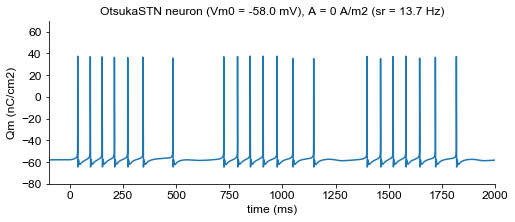

In [10]:
fig = runAndPlot(neuron, None, None, 0., 2., 0.)

We observe a variable spontenaous firing rate between 5 and 20 Hz, with an average of about 13-14 Hz. This is slightly higher than that reported by Otsuka (approx. 10 Hz), but within the same order of magnitude. 

### Response to depolarizing current pulses

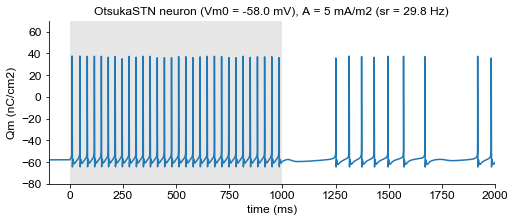

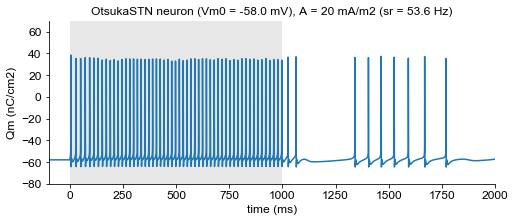

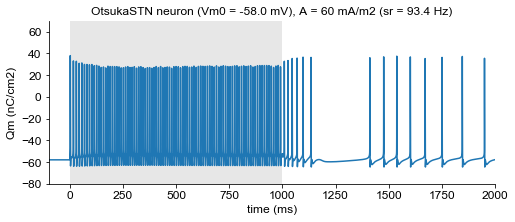

In [11]:
for A in [5., 20., 60.]:
    fig = runAndPlot(neuron, None, None, A, 1., 1., sr_interval='ON')

As expected, injection of depolarizing current induces an increase in the neuron's firing rate. Furthermore, the detected firing rates at 5, 20 and 60 mA/m2 current injection correspond to those indicated by Otsuka.

### Generation of plateau potentials

Here, we simply re-initialize the STN neuron at a membrane potential lower than its resting potential, in order to mimick the effect of a hyperpolarizing current that would drive the membrane to a hyperpolarized state and hence suppress the neuron's spontaneous activity.

Then, we inject a short depolarizing pulse (50 ms, similarly as in Otsuka 2004), in order to elicit the plateau potential burst of spikes. 

Due to the current implementation, no hyperpolarizing current can be injected after the depolarizing pulse, hence the neuron's spontaneous activity can re-occur after the burst. 

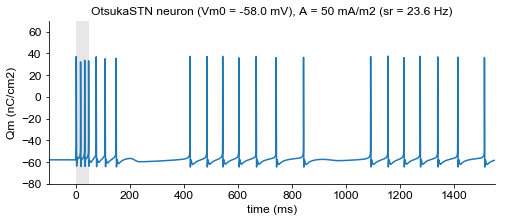

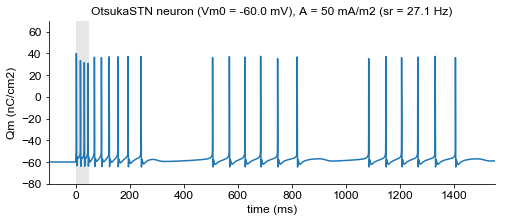

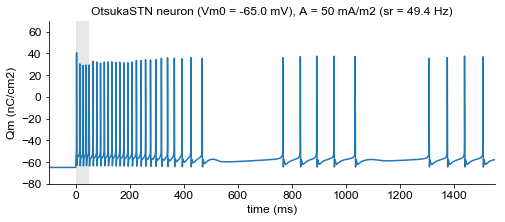

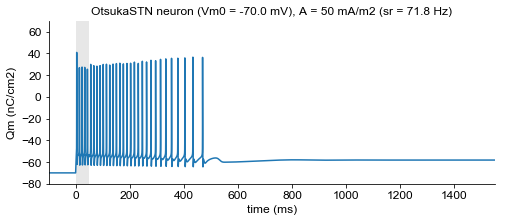

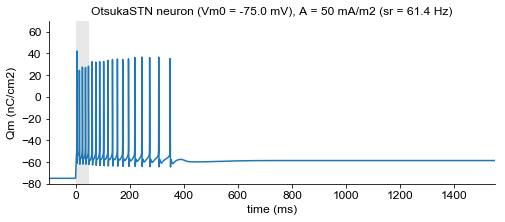

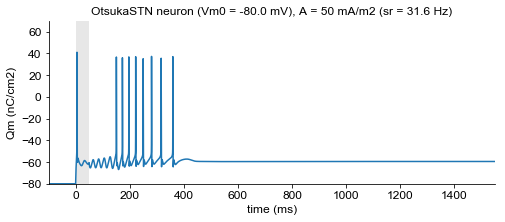

In [12]:
for Vm0 in [-58, -60, -65, -70., -75., -80.0]:
    fig = runAndPlot(neuron, None, None, 50., 0.05, 1.5, Vm0=Vm0)

Despite the slight difference of implementation, we still observe the presence of a burst of spikes that start s at the onset of the depolarizing pulse and then outlasts the stimulus duration.

We also notice that the duration of this burst seems to effectively depend on the initial value of membrane potential, with an optimum of approx. -70 mV at which the burst duration is maximal. This corroborates with the voltage-dependency of plateau potential generation observed in Otsuka 2004.

### Rebound bursting after hyperpolarizing pulses

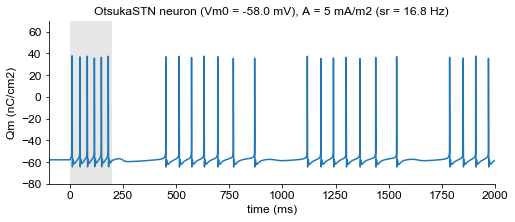

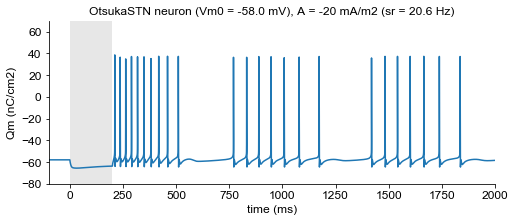

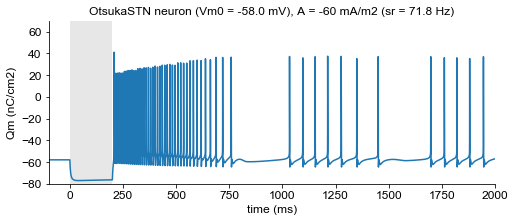

In [13]:
for A in [5., -20., -60.]:
    fig = runAndPlot(neuron, None, None, A, 0.2, 1.8)

We also observe the generation of rebound bursts at the offset of short hyperpolarizing pulses. Again, the burst spike rate and duration is dependent on the intensity of the hyperpolarizing pulse.

### Typical response to US CW stimulation

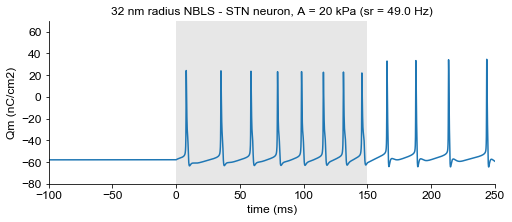

In [3]:
fig = runAndPlot(neuron, 32e-9, 500e3, 20e3, 0.15, 0.1)

I = 10 W/m2 (A = 5.58 kPa)
I = 110 W/m2 (A = 18.51 kPa)
I = 115 W/m2 (A = 18.93 kPa)
I = 127 W/m2 (A = 19.89 kPa)


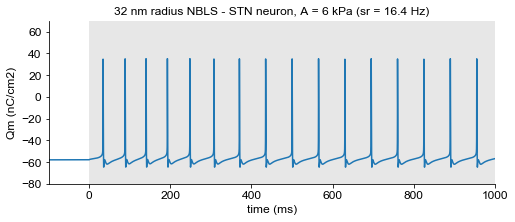

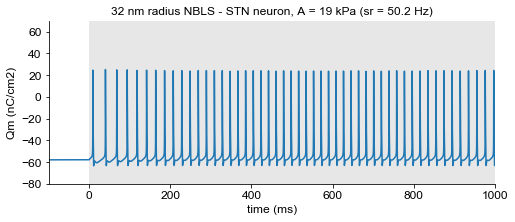

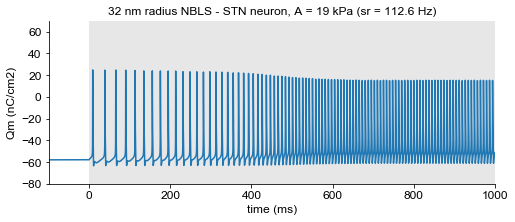

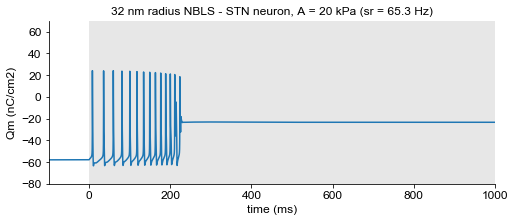

In [8]:
for I in [10, 110, 115, 127]:
    A = Intensity2Pressure(I, rho=1028.0)
    print('I = {:.0f} W/m2 (A = {:.2f} kPa)'.format(I, A * 1e-3))
    fig = runAndPlot(neuron, 32e-9, 500e3, A, 1.0, 0.0)

We observe a transition between different spiking regimes as a function of acoustic intensity:
- for small intensities (10 to 110 W/m2), the acoustic simulus simply excites the neuron at a constant firing rate, higher than its spontaneous physiological counterpart. Within this regime, increasing acoustic intensity simply raises the obtained firing rate.
- for intermediate intensities (115 W/m2), the acoustic stimulus triggers a neural response in which the firing pattern evolves in time, with spikes increasing in frequency and decrease in amplitude.
- for high intensities (127 W/m2), the acoustic stimulus triggers a few spikes and then a slienced plateau potential.

All those observations are qualitatively similar to those of Tarnaud 2018 for the same intensities (Fig 1).